# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

## Local Setup

#### ⚠️ Note:
If you are running this starting kit locally, you may want to use a dedicated conda env.  
[Instructions to setup a conda env](https://github.com/FAIR-Universe/HEP-Challenge/tree/master/conda)

#### ⚠️ Note:
If you are running this starting kit on MAC OS, you may want to check and install `libomp` package. 
This package is needed to run xgboost model. Follow the steps below for complete installations.

If still you are facing problems with XGBoost, you can uninstall the current xgboost and install py-xgboost in your environment

Uninstall XGBoost
```
pip uninstall xgboost
```

Install py-xgboost using conda
```
conda install py-xgboost
```

## COLAB Setup
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone --depth 1 https://github.com/FAIR-Universe/HEP-Challenge.git

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

    # Install required packages
    # %pip install -r conda/requirements.txt 

In [3]:
TEST_SETTINGS = {
"systematics": {  # Systematics to use
    "tes": True, # tau energy scale
    "jes": False, # jet energy scale
    "soft_met": False, # soft term in MET
    "ttbar_scale": False, # ttbar scale factor
    "diboson_scale": False, # diboson scale factor
    "bkg_scale": False, # Background scale factor
    },
"num_pseudo_experiments" : 4 , # Number of pseudo-experiments to run per set
"num_of_sets" : 3, # Number of sets of pseudo-experiments to run
} 

USE_RANDOM_MUS = True
USE_TEST_MODEL = True

## Existing Submissions
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

### Imports

In [4]:
import os
import json
import datetime
import numpy as np
from sys import path
from zipfile import ZipFile, ZIP_DEFLATED
from contextlib import closing

### Directories

In [5]:

root_dir = os.getcwd()
print("Root directory is", root_dir)

input_dir = os.path.join(root_dir, "input_data")
output_dir = os.path.join(root_dir, "sample_result_submission")
program_dir = os.path.join(root_dir, "ingestion_program")
score_dir = os.path.join(root_dir, "scoring_program")

if USE_TEST_MODEL:
    submission_dir = os.path.join(root_dir, "test_model")
else:
    submission_dir = os.path.join(root_dir, "sample_code_submission")

test_settings = TEST_SETTINGS.copy()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
if USE_RANDOM_MUS:
    test_settings[ "ground_truth_mus"] = (np.random.uniform(0.1, 3, test_settings["num_of_sets"])).tolist()
    
    random_settings_file = os.path.join(output_dir, "random_mu.json")
    with open(random_settings_file, "w") as f:
        json.dump(test_settings, f)
else:
    test_settings_file = os.path.join(input_dir, "test", "settings", "data.json")
    with open(test_settings_file) as f:
        test_settings = json.load(f)

Root directory is /home/chakkappai/Work/Fair-Universe/HEP-Challenge



### Add directories to path

In [6]:
path.append(program_dir)
path.append(submission_dir)
path.append(score_dir)

***
# Internal imports
***

In [7]:
from visualization import *
from systematics import systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [8]:
from model import Model
from datasets import Data

***
## Data
***

### ⚠️ Note:
The data used here is a small sample data is for demonstration only to get a view of what the data looks like. 

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small sample datafor quick execution of this notebook

In [9]:
USE_PUBLIC_DATASET = False

`USE_PUBLIC_DATASET` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [10]:
if USE_PUBLIC_DATASET:
    from datasets import Neurips2024_public_dataset as public_dataset
    data = public_dataset()
else:
    data = Data(input_dir)

The function loads the downloaded data in the public_data folder or downloads the data from codabench using `wget` in the absence of the downloaded data, 

In [11]:
# load train set
data.load_train_set()

[*] Loading Train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220790 entries, 0 to 220789
Columns: 16 entries, PRI_lep_pt to PRI_met_phi
dtypes: float32(16)
memory usage: 13.5 MB
None
[+] Train data loaded successfully


In [12]:
# load test sets
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


***
# Visualize
***
- Visualize Train set

In [13]:
data_vis = systematics(data.get_train_set())

train_visualize = Dataset_visualise(
    data_set=data_vis,
    columns=[
        "PRI_jet_leading_pt",
        "PRI_met",
        "DER_mass_vis",
        "DER_mass_jet_jet",
        "DER_sum_pt",
    ],
    name="Train Set",
)

In [14]:
# Show data summary
train_visualize.examine_dataset()

[*] --- Dataset name : Train Set
[*] --- Number of events : 198748
[*] --- Number of features : 28
   diboson   3397.271748563058
   htautau   972.4861299716068
   ttbar   41132.73717044972
   ztautau   900920.2938237669
[*] --- Number of signal events : 204
[*] --- Number of background events : 198544
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
0,25.412001,-0.555,1.975,28.997999,0.351,-1.838,54.056000,1.636,-0.244,26.354,...,24.689272,1.513,95.622383,5.151764,2.631094,12.235117,134.820007,0.876336,0.701390,2.553498e-07
1,39.563000,0.586,3.058,28.274000,0.735,0.084,-25.000000,-25.000,-25.000,-25.000,...,4.905827,-25.000,-25.000000,-25.000000,2.977730,4.905827,67.836998,1.399271,-1.390982,-2.500000e+01
2,22.320000,0.801,2.521,29.041000,-0.735,-0.864,26.881001,-1.195,0.180,-25.000,...,17.722971,-25.000,-25.000000,-25.000000,3.280057,12.030704,78.242004,0.768569,1.092476,-2.500000e+01
3,24.546000,2.164,1.908,38.452999,0.426,-2.151,-25.000000,-25.000,-25.000,-25.000,...,40.089237,-25.000,-25.000000,-25.000000,2.822702,40.089237,62.999001,0.638338,1.252621,-2.500000e+01
4,29.172001,-1.224,1.808,34.316002,0.200,-1.314,-25.000000,-25.000,-25.000,-25.000,...,5.194582,-25.000,-25.000000,-25.000000,3.431422,5.194582,63.488003,0.850099,1.412232,-2.500000e+01


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,...,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_had_lep,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_met_phi_centrality,DER_lep_eta_centrality
count,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,...,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000,198748.000000
mean,31.055611,-0.000968,0.001295,40.249752,-0.001081,-0.002889,3.693358,-16.965078,-16.972868,-15.893944,...,29.903156,-21.682407,3.686546,-21.877492,2.829481,16.627062,101.731407,0.821261,0.144721,-21.906352
std,14.442051,1.251263,1.814263,15.208206,1.265087,1.812137,49.478409,11.718164,11.711324,26.603773,...,37.784561,8.965718,107.458019,8.880477,0.538238,14.001334,82.930046,0.382258,1.257392,8.301904
min,20.000000,-2.500000,-3.142000,26.000000,-2.673000,-3.142000,-25.000000,-25.000000,-25.000000,-25.000000,...,0.011628,-25.000000,-25.000000,-111.600006,0.591869,0.011628,46.078999,0.053625,-1.414214,-25.000000
25%,23.334000,-0.991000,-1.573000,31.452000,-1.000000,-1.572000,-25.000000,-25.000000,-25.000000,-25.000000,...,9.200467,-25.000000,-25.000000,-25.000000,2.691232,7.957961,61.244999,0.599296,-1.383972,-25.000000
50%,27.514000,-0.004000,0.000000,37.157001,-0.006000,0.000000,-25.000000,-25.000000,-25.000000,-25.000000,...,16.926866,-25.000000,-25.000000,-25.000000,3.010935,13.484183,71.712997,0.748874,0.778724,-25.000000
75%,33.799000,0.989000,1.578000,44.409000,0.999000,1.563000,32.238998,-1.401000,-1.775000,-25.000000,...,33.206376,-25.000000,-25.000000,-25.000000,3.139685,21.322845,103.128998,0.945720,1.390993,-25.000000
max,515.867004,2.500000,3.142000,464.765015,2.668000,3.142000,780.448975,4.834000,3.142000,490.860992,...,705.035400,29.464001,4245.830078,625.000000,5.649345,404.146729,1582.538086,11.784817,1.414214,1.000000


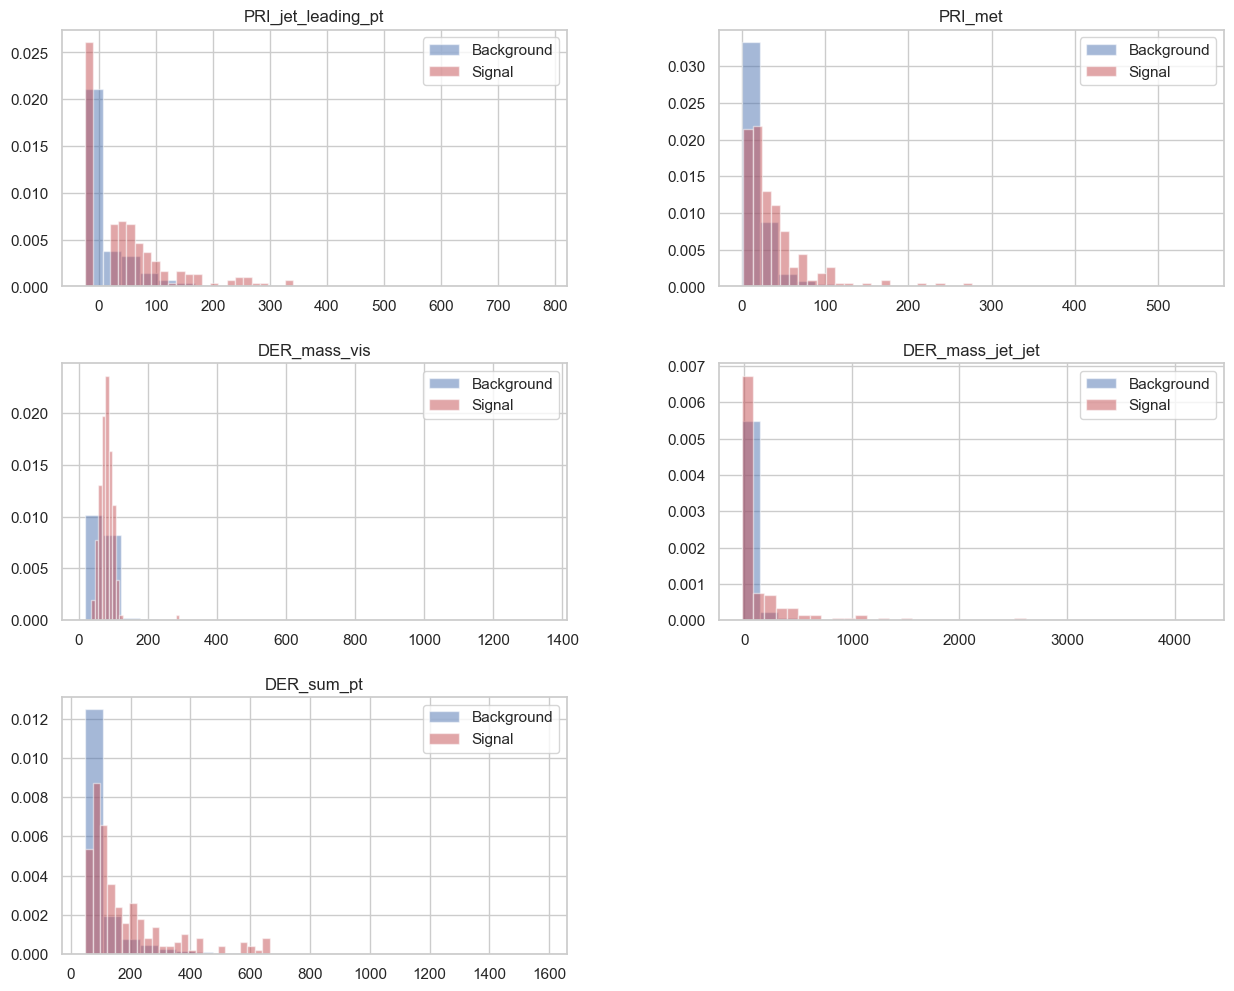

In [15]:
# Show data summary
train_visualize.histogram_dataset()

diboson (713,)
diboson (713,)
htautau (30,)
ttbar (8638,)
ttbar (8638,)
ztautau (189193,)
ztautau (189193,)


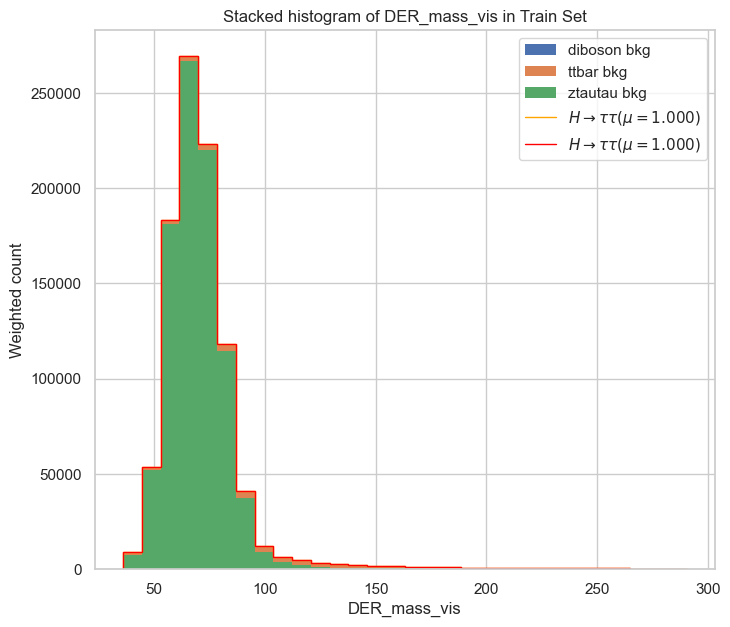

In [16]:
train_visualize.stacked_histogram("DER_mass_vis")

/home/chakkappai/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


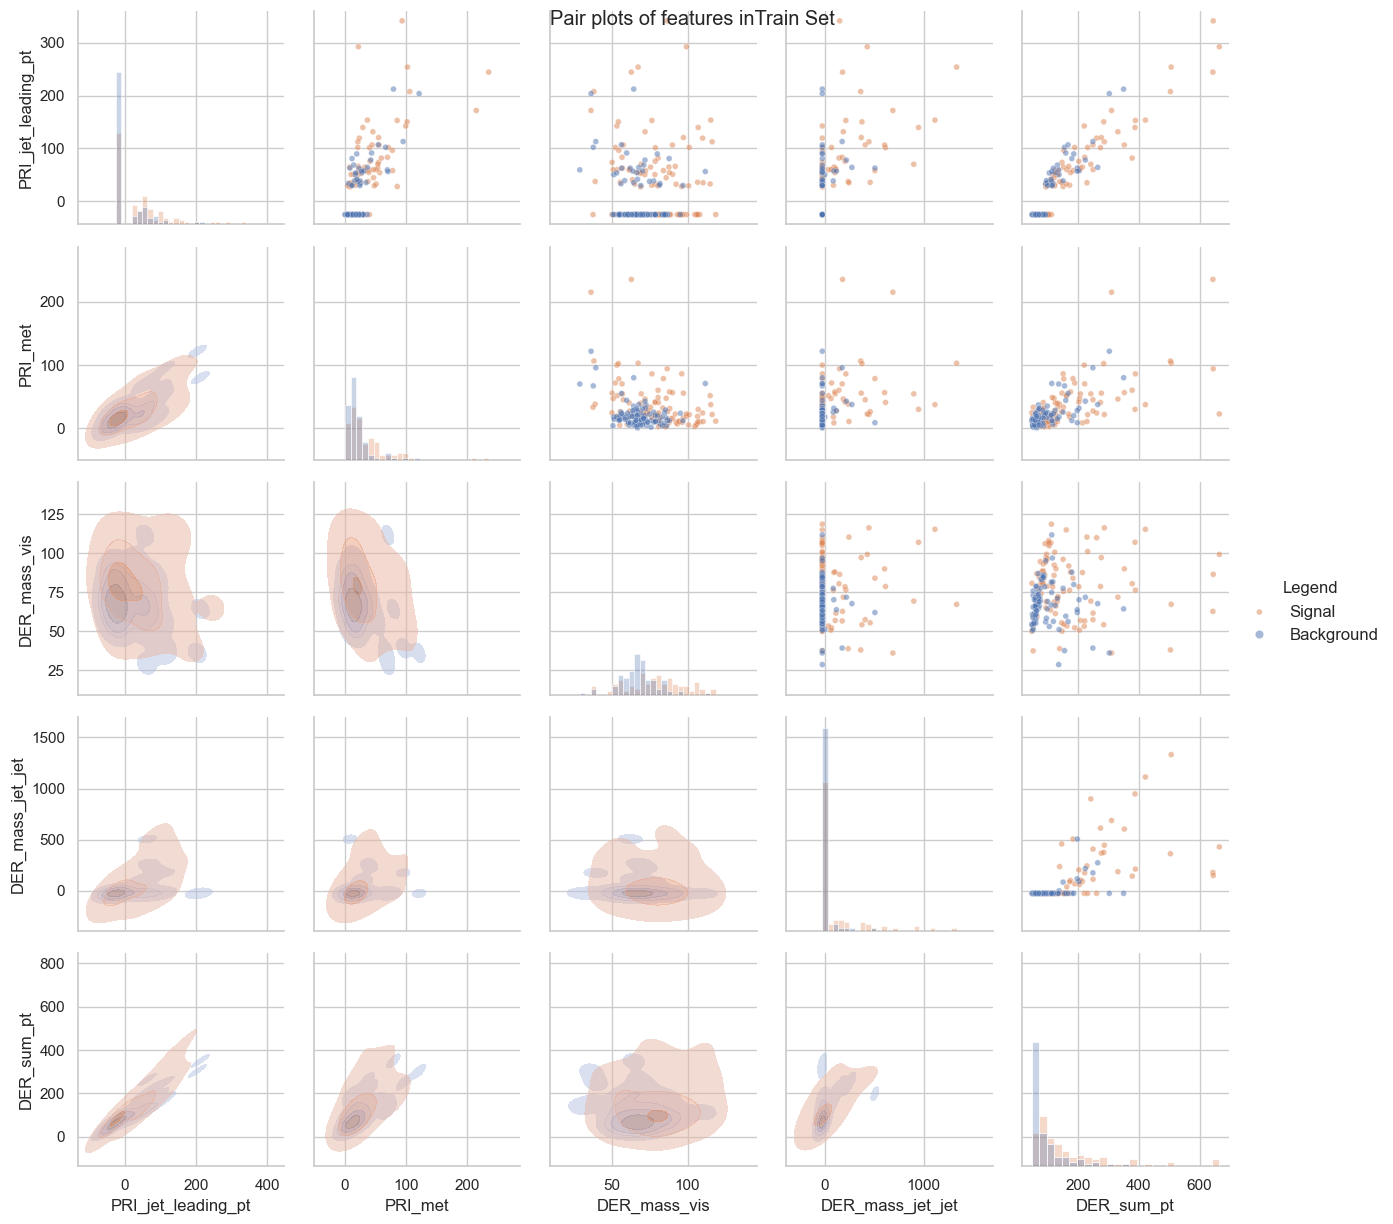

In [17]:
# Show data summary
train_visualize.pair_plots(sample_size=100)

In [18]:
syst_train_data = data.get_syst_train_set()

/home/chakkappai/miniconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:186: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


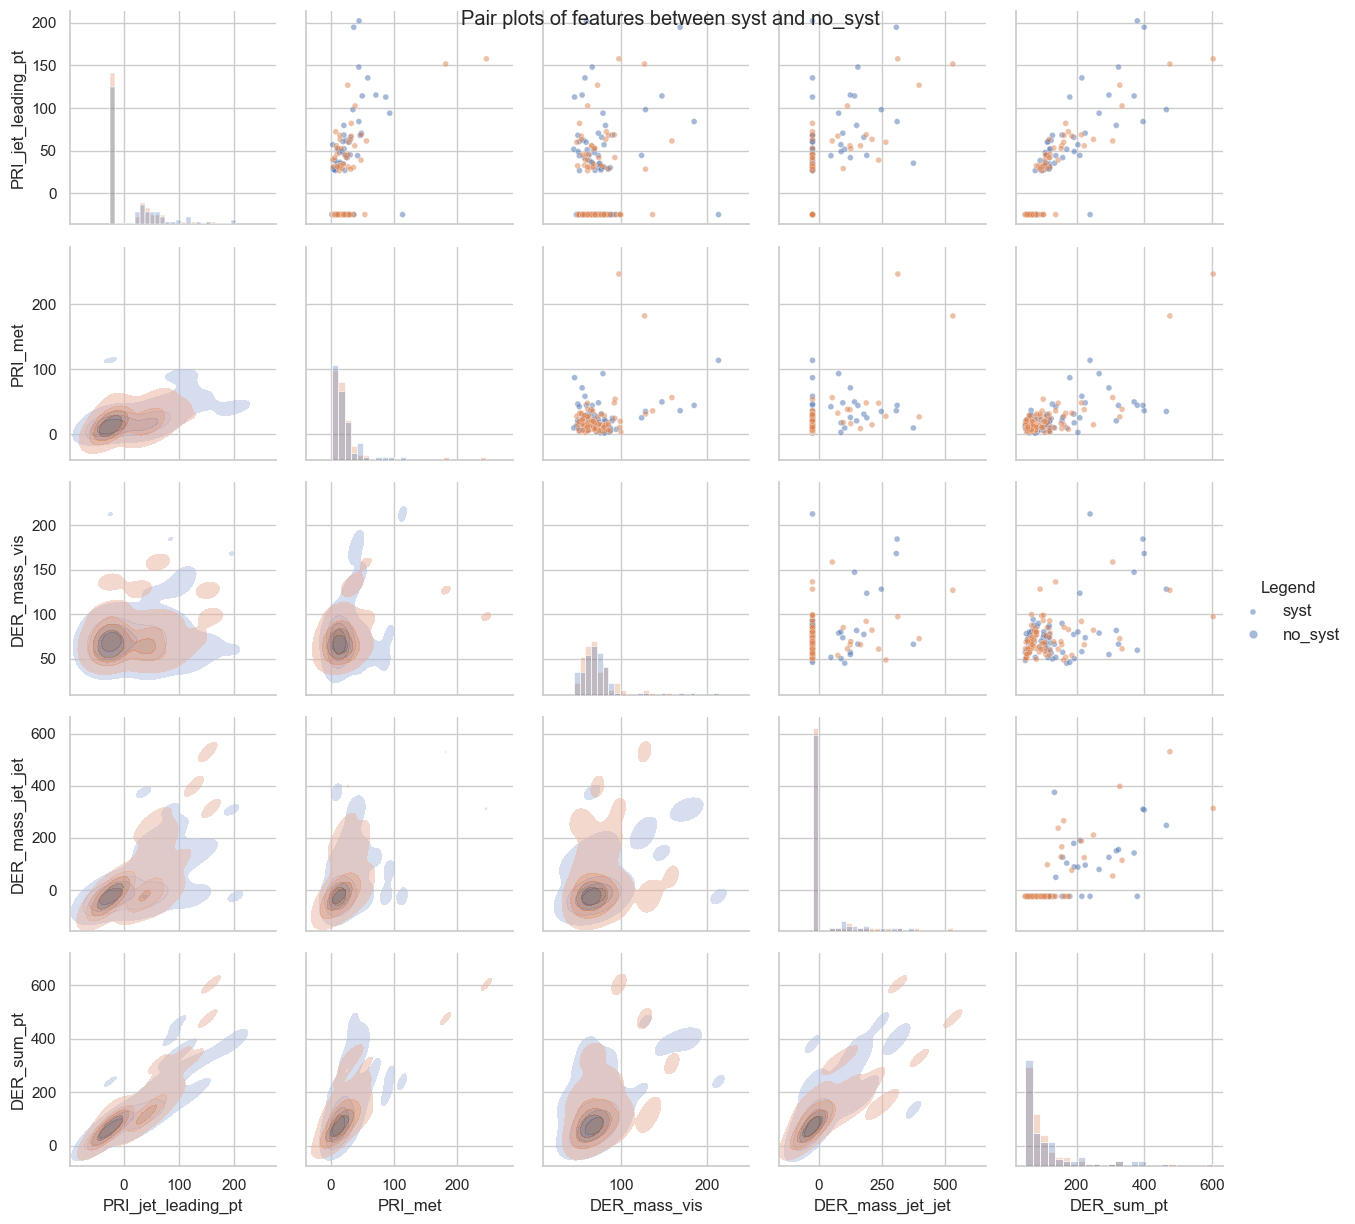

In [19]:
# Pair plots of train set with systematics
train_visualize.pair_plots_syst(syst_train_data["data"], sample_size=100)

***
### Program
***


In [20]:

from ingestion import Ingestion

ingestion = Ingestion(data)


In [21]:

# initialize submission
ingestion.init_submission(Model)

[*] Initializing Submmited Model


2024-08-27 10:54:23.372439: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-27 10:54:23.396446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 10:54:23.396477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 10:54:23.397134: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 10:54:23.401759: I tensorflow/core/platform/cpu_feature_guar

## Statistical Tools
In the process of data fitting using our ingestion module, there are two primary arguments that control how the fit is performed: stat_only and syst_settings.
- `stat_only (bool, optional)`: This argument, when set to True, forces the fitting process to compute statistics-only results. This means that only statistical uncertainties are considered, and all systematic uncertainties are ignored.
- `syst_settings (dict, optional)`: This argument is a dictionary that specifies the systematic settings, indicating whether to fix certain systematics during the fitting process. Each entry in the dictionary represents a different systematic uncertainty, with a boolean value indicating whether it should be **fixed** (True) or allowed to **float** (False).

Note that the `syst_settings` is used to only control the systematics that are allowed to float during the fitting process. It is different from the `TEST_SETTINGS['systematics']` which is used to specify the systematics to be used in the test set generation.

In [22]:

# fit submission
ingestion.fit_submission()

[*] Calling fit method of submitted model


In [23]:
# load test set
data.load_test_set()

[*] Loading Test data
[+] Test data loaded successfully


In [24]:

# predict submission
ingestion.predict_submission(test_settings)

[*] Calling predict method of submitted model
29600/29600 [==============================] - 32s 1ms/step
Test Results:  {'mu_hat': 0.7062661295969133, 'del_mu_stat': 0.7285539777812633, 'del_mu_sys': 0.07062661295969133, 'del_mu_tot': 0.36598463663078107}
[*] - mu_hat: 0.7062661295969133 - delta_mu_hat: 0.36598463663078107 - p16: 0.3402814929661322 - p84: 1.0722507662276943
29517/29517 [==============================] - 31s 1ms/step
Test Results:  {'mu_hat': -0.3685033750216527, 'del_mu_stat': 0.7285539777812633, 'del_mu_sys': 0.03685033750216527, 'del_mu_tot': 0.364742664736018}
[*] - mu_hat: -0.3685033750216527 - delta_mu_hat: 0.364742664736018 - p16: -0.7332460397576708 - p84: -0.003760710285634683
29641/29641 [==============================] - 34s 1ms/step
Test Results:  {'mu_hat': 0.8615297819495151, 'del_mu_stat': 0.7285539777812633, 'del_mu_sys': 0.08615297819495152, 'del_mu_tot': 0.3668150876779611}
[*] - mu_hat: 0.8615297819495151 - delta_mu_hat: 0.3668150876779611 - p16: 0.4

In [25]:
ingestion.compute_result()

[*] Saving ingestion result


In [26]:

# save result
!rm -rf $output_dir/*
ingestion.save_result(output_dir)

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [27]:
from score import Scoring

In [28]:
# Initialize Score
score = Scoring()

In [29]:
score.load_ingestion_results(output_dir)

[*] Reading predictions
[✔]


[*] Computing scores
------------------
Set 0
------------------
MAE (avg): 1.3750237497472817
RMSE (avg): 1.2358817487326628
Interval: 0.7388886555266724
Coverage: 0.0
Quantiles Score: -0.2640016413594601
------------------
Set 1
------------------
MAE (avg): 2.932844399509496
RMSE (avg): 3.5795578206383194
Interval: 0.8502091911072168
Coverage: 0.0
Quantiles Score: -0.40415984833922297
------------------
Set 2
------------------
MAE (avg): 2.1971232418684683
RMSE (avg): 2.3565180450270673
Interval: 0.752689270941971
Coverage: 0.25
Quantiles Score: 0.2827751034178326


Overall Score
[*] --- RMSE: 2.391
[*] --- MAE: 2.168
[*] --- Interval: 0.781
[*] --- Coverage: 0.083
[*] --- Quantiles score: -3.383
[*] --- Ingestion duration: None
[✔]


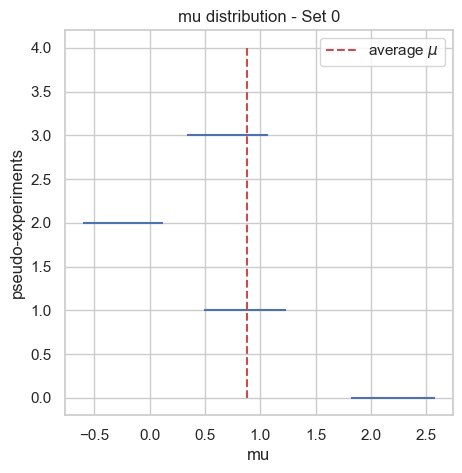

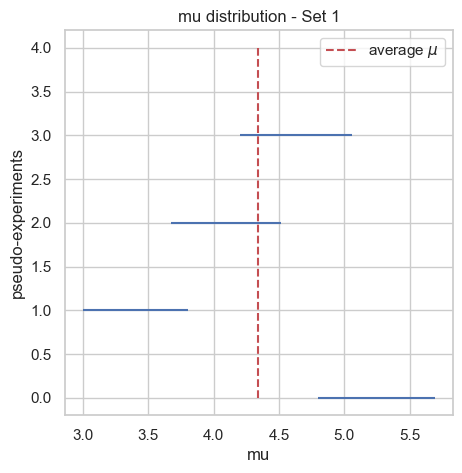

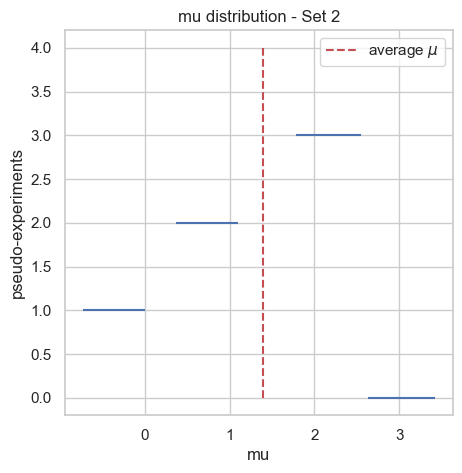

In [30]:
# Compute Score
score.compute_scores(test_settings)

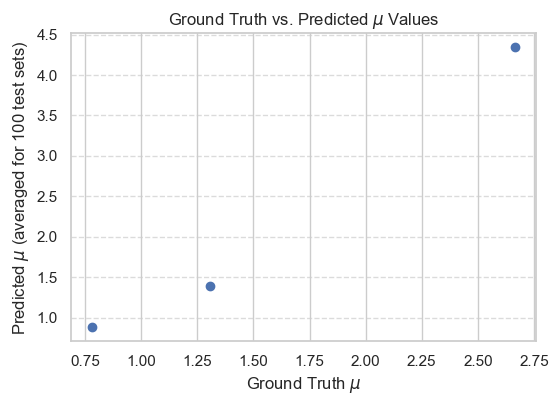

In [31]:
# Visualize scatter plot of ground truth mu and predicted mu
visualize_scatter(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

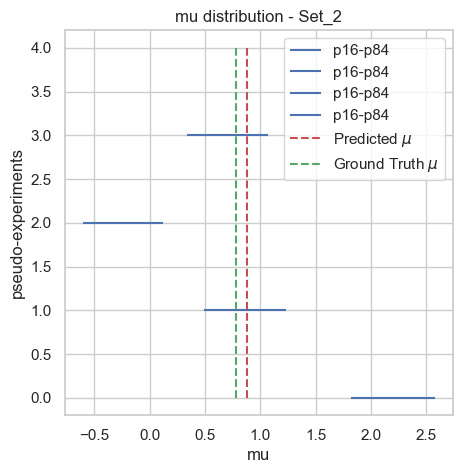

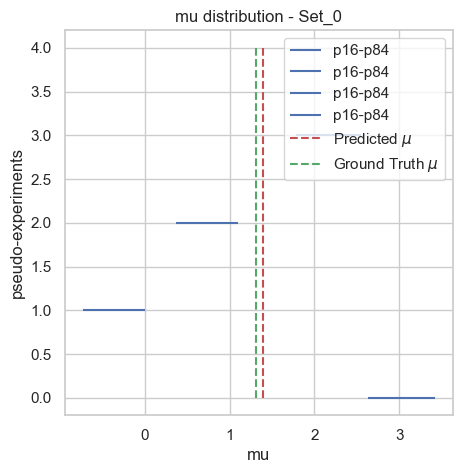

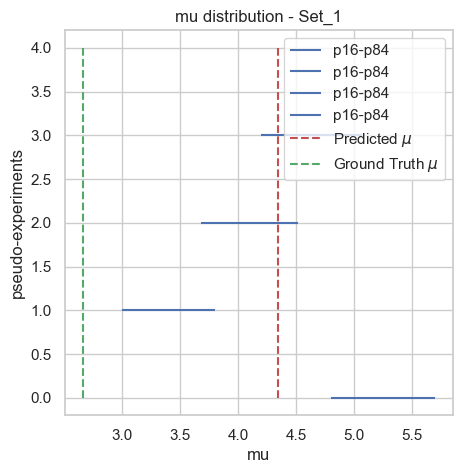

In [32]:
# Visualize coverage
visualize_coverage(ingestion_result_dict=ingestion.results_dict, 
                  ground_truth_mus=test_settings["ground_truth_mus"])

***
# Submission
***

### **Prepare the submission**

In [33]:
def zipdir(archivename, basedir):
    '''Zip directory, from J.F. Sebastian http://stackoverflow.com/'''
    assert os.path.isdir(basedir)
    with closing(ZipFile(archivename, "w", ZIP_DEFLATED)) as z:
        for root, dirs, files in os.walk(basedir):
            # NOTE: ignore empty directories
            for fn in files:
                if fn[-4:] != '.zip' and fn != '.DS_Store':
                    absfn = os.path.join(root, fn)
                    zfn = absfn[len(basedir):]  # XXX: relative path
                    z.write(absfn, zfn)

In [34]:
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'Submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

Submit : HiggsML-code_submission_24-08-27-11-01.zip to the competition
You can find the zip file in `HEP-Challenge/
